# Bias-Variance Tradeoff

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import numpy as np
from numpy.random import randint, choice, normal, shuffle
import pandas as pd

from scipy.special import factorial

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
sns.set_style('whitegrid')

## Generate Sample Data

In [4]:
def f(x, max_degree=5): #x可为一个array
    taylor = [(-1)**i * x ** e / factorial(e) for i, e in enumerate(range(1, max_degree+1, 2))] #factorial方法返回阶乘
    return  np.sum(taylor, axis=0) #注意axis=0
#定义函数 f(x) =  x - (x^3)/3! + x^5/5!

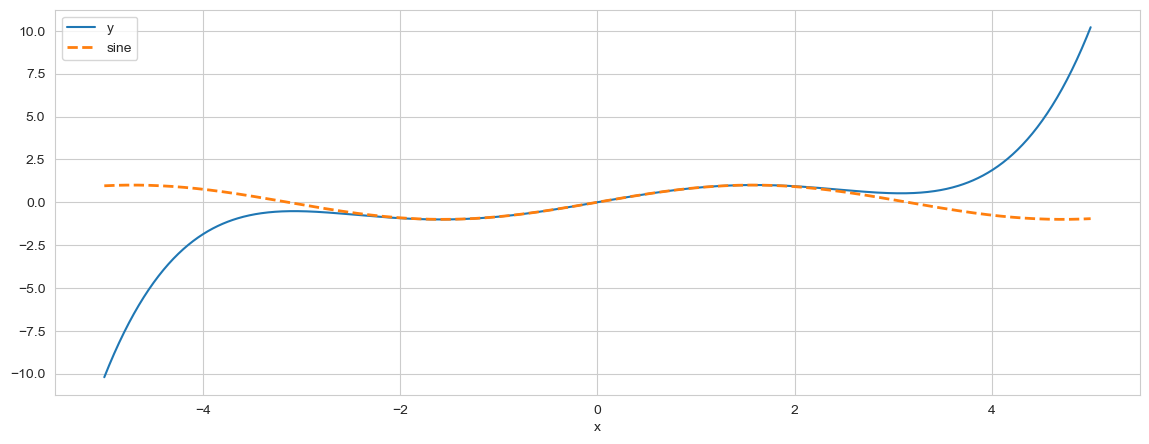

In [5]:
max_degree = 5
fig, ax = plt.subplots(figsize=(14, 5))
x = np.linspace(-5, 5, 1000) #array(-5,-5+10/999,...,5)

data = pd.DataFrame({'y': f(x, max_degree), 'x': x})
data.plot(x='x', y='y', legend=False, ax=ax)
pd.Series(np.sin(x), index=x).plot(ax=ax, ls='--', lw=2, label='sine')
plt.legend();

## Underfitting vs overfitting: a visual example

In [6]:
from collections import defaultdict

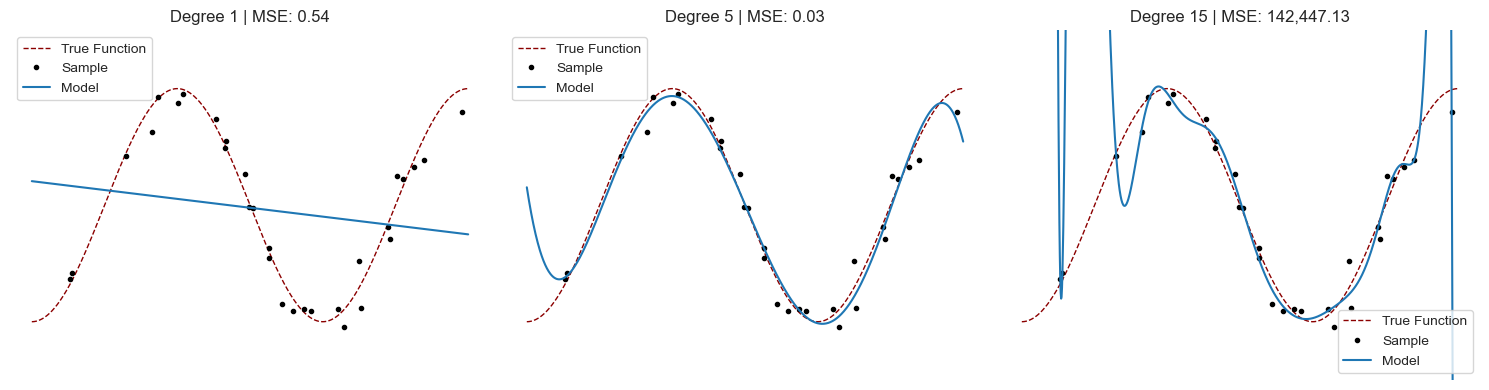

In [7]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))
x = np.linspace(-.5 * np.pi, 2.5 * np.pi, 1000)
true_function = pd.Series(np.sin(x), index=x)
n = 30
noise = 0.2
degrees = [1, 5, 15]
x_ = np.random.choice(x, size=n)  #numpy.random.choice(a, size=None, replace=True, p=None)，对一个一维array list 或tuple进行抽样
y_ = np.sin(x_)
y_ +=  normal(loc=0, scale=np.std(y_) * noise, size=n) #给y加上正态干扰项
mse = defaultdict(list)
for i, degree in enumerate(degrees):
    fit = np.poly1d(np.polyfit(x=x_, y=y_, deg=degree)) #np.polyfit多项式拟合，deg为多项式最高阶数，输出为拟合多项式的参数值（阶数由大到小）
    true_function.plot(ax=axes[i], c='darkred', lw=1, ls='--', label='True Function') #真实方程样本点的点图
    pd.Series(y_, index=x_).plot(style='.', label='Sample', ax=axes[i], c='k') #真实方程抽样吧样本点加上扰动项后的点图
    pd.Series(fit(x), index=x).plot(label='Model', ax=axes[i]) #拟合方程对于y的预测图
    axes[i].set_ylim(-1.5, 1.5)
    mse = mean_squared_error(fit(x), np.sin(x))
    axes[i].set_title(f'Degree {degree} | MSE: {mse:,.2f}')
    axes[i].legend()
    axes[i].grid(False) #删去网格线
    axes[i].axis(False) #删去坐标轴

sns.despine() #sns.despine()函数默认移除了上部和右侧的轴
fig.tight_layout(); #tight_layout会自动调整子图参数，使各个子图标签和标题不重叠，并使之填充至整个区域

## Bias-Variance Tradeoff

### Train Model

In [8]:
datasets = ['Train', 'Test']
X = {'Train': np.linspace(-1, 1, 1000), 'Test': np.linspace(1, 3, 1000)}

models = {'Underfit': 1, 'Right Fit': 5, 'Overfit': 9}

sample = 25
noise = 0.01
result = []
for i in range(100): #一共进行一百次随机抽样程序
    
    x_ = {d: choice(X[d], size=sample, replace=False) for d in datasets} #抽样
    y_ = {d: f(x_[d], max_degree=5) for d in datasets} #真实方程为x的5阶多项式
    y_['Train'] += normal(loc=0,
                          scale=np.std(y_['Train']) * noise,
                          size=sample) #添加扰动项

    trained_models = {
        fit: np.poly1d(np.polyfit(x=x_['Train'], y=y_['Train'], deg=deg))
        for fit, deg in models.items()
    }  #{'Underfit':训练组的对应拟合方程, ... }
 
    for fit, model in trained_models.items(): #每一次随机抽样程序拟合3种模型
        for dataset in datasets: #每个拟合模型最终都要算训练组和测试组的误差
            pred = model(x_[dataset]) #利用拟合方程生成对应y预测值
            result.append(
                pd.DataFrame(
                    dict(x=x_[dataset],
                         Model=fit,
                         Data=dataset,
                         y=pred,
                         Error=pred - y_[dataset]))) #dataframe会自动补齐
result = pd.concat(result) #默认axis=0
result

,x,Model,Data,y,Error
0,0.461461,Underfit,Train,0.420790,-0.020498
1,-0.517518,Underfit,Train,-0.467188,0.022653
2,0.719720,Underfit,Train,0.655042,-0.005472
3,0.739740,Underfit,Train,0.673201,0.005863
4,0.575576,Underfit,Train,0.524297,-0.022220
...,...,...,...,...,...
20,2.491491,Overfit,Test,-3540.519441,-3541.233312
21,1.116116,Overfit,Test,-0.310789,-1.209611
22,2.809810,Overfit,Test,-10539.386464,-10539.958515
23,1.314314,Overfit,Test,-6.599138,-7.567739


### Plot result

In [9]:
y = {d: f(X[d], max_degree=5) for d in datasets}
y['Train_noise'] = y['Train'] + normal(loc=0,
                                       scale=np.std(y['Train']) * noise,
                                       size=len(y['Train']))
colors = {'Underfit': 'darkblue', 'Right Fit': 'darkgreen', 'Overfit': 'darkred'}
test_data = result[result.Data == 'Test'] #提取出测试的数据

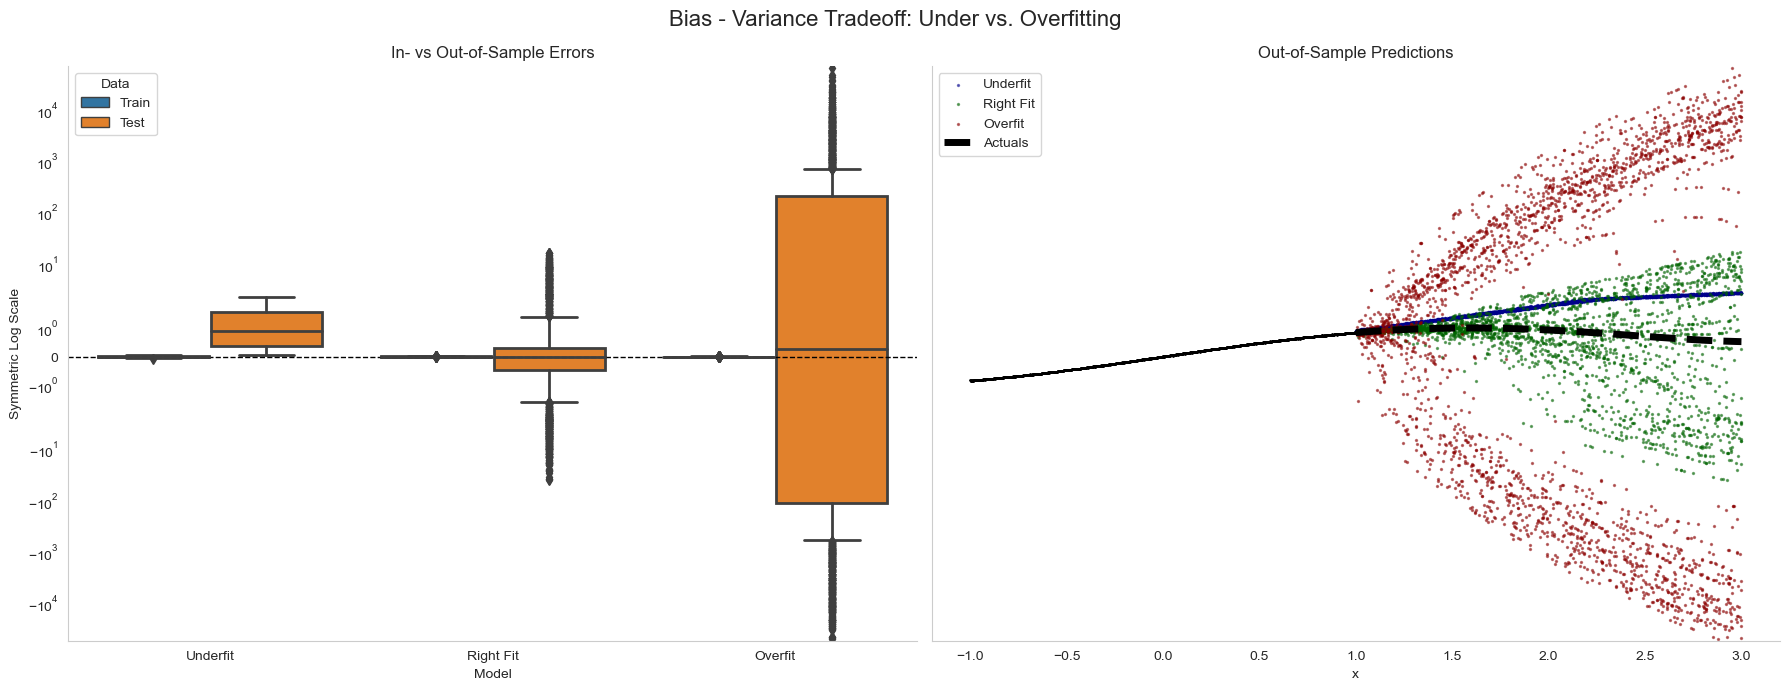

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 7), sharey=True)

sns.boxplot(x='Model', y='Error', hue='Data', data=result, ax=axes[0], linewidth=2)
axes[0].set_title('In- vs Out-of-Sample Errors')
axes[0].axhline(0, ls='--', lw=1, color='k') #绘制水平参考线
axes[0].set_ylabel('Symmetric Log Scale')

for model in colors.keys():
    (test_data[(test_data['Model'] == model)]
     .plot.scatter(x='x',
                   y='y',
                   ax=axes[1],
                   s=2,
                   color=colors[model],
                   alpha=.5,
                   label=model))

# pd.Series(y['Train'], index=X['Train']).sort_index().plot(ax=axes[1], title='Out-of-sample Predictions')
pd.DataFrame(dict(x=X['Train'], y=y['Train_noise'])).plot.scatter(x='x', y='y', ax=axes[1], c='k', s=1)
pd.Series(y['Test'], index=X['Test']).plot(color='black', lw=5, ls='--', ax=axes[1], label='Actuals')

axes[0].set_yscale('symlog') #对y取对数缩放
axes[1].set_title('Out-of-Sample Predictions')
axes[1].legend()
axes[0].grid(False)
axes[1].grid(False)
sns.despine()
fig.tight_layout()
fig.suptitle('Bias - Variance Tradeoff: Under vs. Overfitting', fontsize=16)
fig.subplots_adjust(top=0.9)

## Learning Curves

In [11]:
def rmse(y, x, model): #rmse应该越小越好
    return np.sqrt(mean_squared_error(y_true=y, y_pred=model.predict(x)))

In [12]:
def create_poly_data(data, degree): #生成更多X数据
    return np.hstack((data.reshape(-1, 1) ** i) for i in range(degree + 1)) #np.hstack将元素数组按水平方向进行叠加

array([x1,x2,....,xn])

array([
    [1,1,...,1],
    [x1,x2,...,xn],
    ...
    [x1,x2,....,xn]^degree
])

array([
    [1,x1,...,x1^degree],
    ...
    [1,x1,...,xn^degree]
])

In [13]:
def folds(train, test, nfolds): #将train和test样本集打乱后，再均分为nfolds份，并用迭代器依次传出
    shuffle(train) #shuffle将列表里的元素随机排列
    shuffle(test)
    steps = (np.array([len(train), len(test)]) / nfolds).astype(int)
    for fold in range(nfolds):
        i, j = fold * steps
        yield train[i:i + steps[0]], test[j: j+steps[1]]

In [14]:
train_set = X['Train'] + normal(scale=np.std(f(X['Train']))) * 0.2  # X = {'Train': np.linspace(-1, 1, 1000), 'Test': np.linspace(1, 3, 1000)}
test_set =  X['Test'].copy()  

sample_sizes = np.arange(0.1, 1.0, 0.01)
indices = ([len(train_set), len(test_set)] * sample_sizes.reshape(-1, 1)).astype(int) #得到一个从100,100到1000,1000的长数据框
result = []
lr = LinearRegression() #此线性回归函数默认fit_intercept=True，即以有截距项来处理。若X有一列或几列全为1，则自动并入截距项处理，而对应的系数为0

for label, degree in models.items(): # models = {'Underfit': 1, 'Right Fit': 5, 'Overfit': 9}
    model_train = create_poly_data(train_set, degree)
    model_test = create_poly_data(test_set, degree)
    for train_idx, test_idx in indices: #从小到大分配不同数量的训练和测试样本集
        train = model_train[:train_idx]
        test = model_test[:test_idx]
        train_rmse, test_rmse = [], []
        for x_train, x_test in folds(train, test, 5): #在给定模型下，对给定总样本进行划分为5对训练和测试集，并训练和计算相应rmse
            y_train, y_test = f(x_train[:, 1], max_degree=5), f(x_test[:, 1], max_degree=5) #生成对应的y值
            lr.fit(X=x_train, y=y_train)
            train_rmse.append(rmse(y=y_train, x=x_train, model=lr))
            test_rmse.append(rmse(y=y_test, x=x_test, model=lr))
        result.append([label, train_idx,
                       np.mean(train_rmse), np.std(train_rmse),
                       np.mean(test_rmse), np.std(test_rmse)])

result = (pd.DataFrame(result,
                       columns=['Model', 'Train Size',
                                'Train RMSE', 'Train RMSE STD',
                                'Test RMSE', 'Test RMSE STD'])
          .set_index(['Model', 'Train Size'])) #让'Model', 'Train Size'作为二重序号

result

Train RMSE  Train RMSE STD     Test RMSE  Test RMSE STD
Model    Train Size                                                           
Underfit 100         1.097098e-03    4.213746e-05  3.948355e-01   1.006482e-02
         110         1.328104e-03    1.525220e-04  3.767997e-01   8.987174e-03
         120         1.499362e-03    1.452351e-04  3.573081e-01   1.744368e-02
         130         1.773210e-03    1.966260e-04  3.394619e-01   1.253422e-02
         139         2.081323e-03    2.481446e-04  3.270904e-01   8.404253e-03
...                           ...             ...           ...            ...
Overfit  949         3.750260e-16    1.209954e-16  4.720587e-11   3.514591e-11
         959         3.212091e-16    9.963195e-17  1.376932e-11   7.737699e-12
         969         3.422885e-16    2.327038e-16  3.053305e-11   5.598030e-12
         979         4.830877e-16    2.683651e-16  3.313942e-11   2.697445e-11
         989         2.754034e-16    8.581225e-17  3.021649e-11   1.455054e-11

[270 rows x 4 columns]

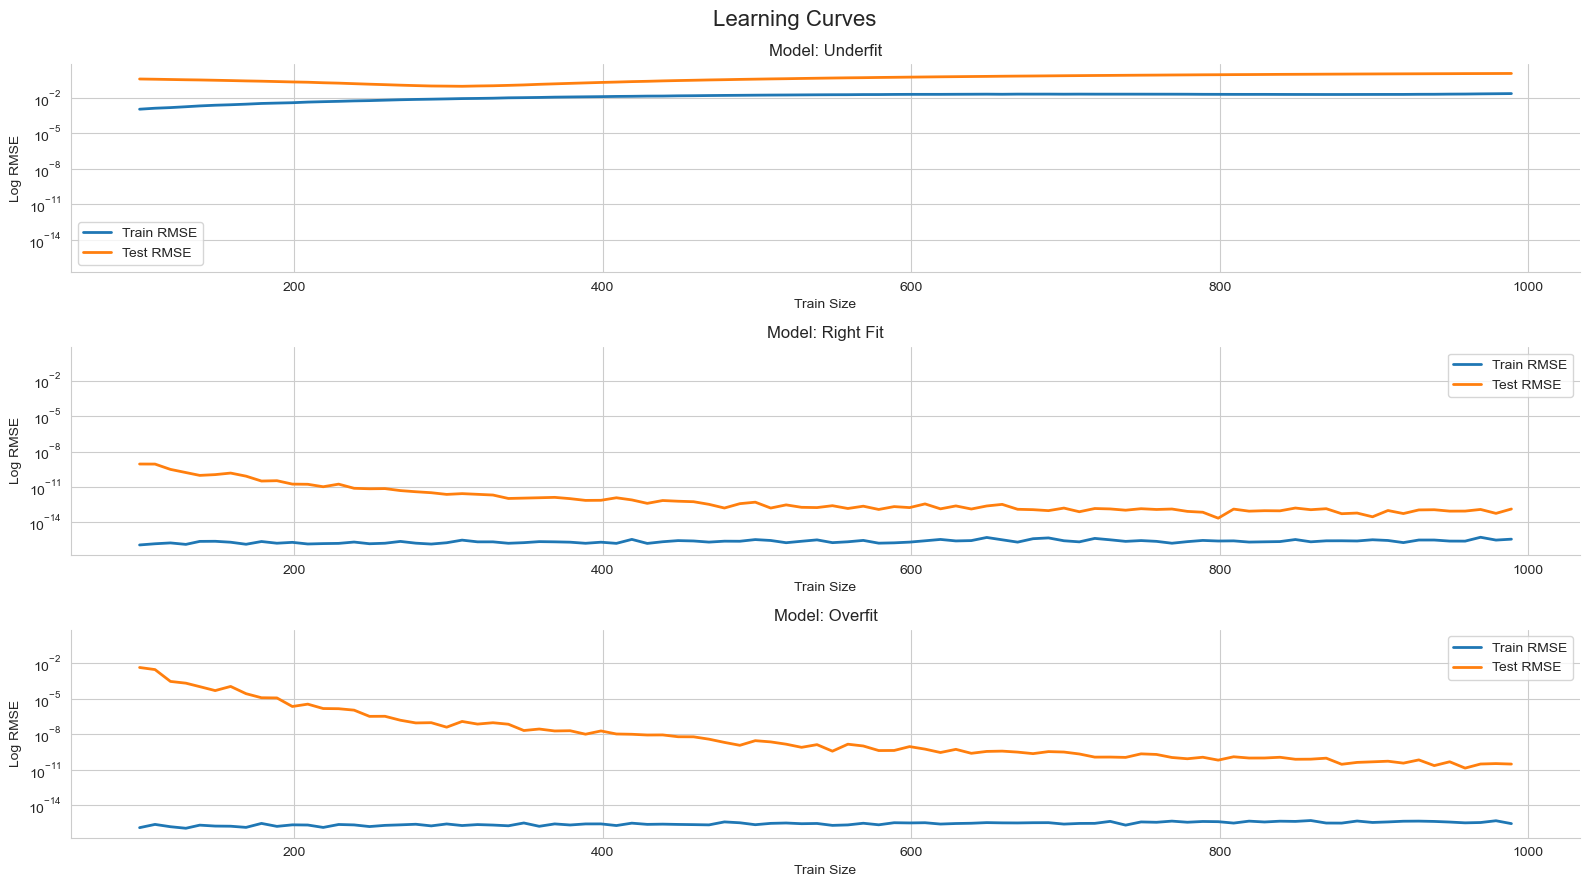

In [15]:
fig, axes = plt.subplots(nrows=3, sharey=True, figsize=(16, 9))
for i, model in enumerate(models.keys()):
    result.loc[model, ['Train RMSE', 'Test RMSE']].plot(ax=axes[i], title=f'Model: {model}', logy=True, lw=2)
    axes[i].set_ylabel('Log RMSE')

fig.suptitle('Learning Curves', fontsize=16)
fig.tight_layout()
sns.despine()
fig.subplots_adjust(top=.92);